# Traffic light detection in real word

The goal of this jupyter notebook is to test the 3rd solution. Further exaplanations are provided in the README file

## library imports, env set up

In [1]:
import os
import cv2
import matplotlib
import sys
import tensorflow as tf
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
from collections import defaultdict

matplotlib.use('TkAgg')
%matplotlib inline


## Model and label imports

In [2]:
# Adding the research folder to the system path]
script_dir = os.getcwd()
research_dir = os.path.join(script_dir, "research")
slim_dir = os.path.join(research_dir, "slim")

sys.path.append(research_dir)
sys.path.append(slim_dir)

In [3]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)


# Load Frozen Model
frozen_model_file = "./model/frozen_inference_graph.pb"
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(frozen_model_file, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    

# Load labels
current_dir = os.getcwd()
labels_file = os.path.join(current_dir, "model/mscoco_label_map.pbtxt")
category_index = label_map_util.create_category_index_from_labelmap(labels_file, use_display_name=True)


## Detection

In [4]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
        return output_dict

## Run inference on taken pictures, cropping the traffic light and storing it 

In [7]:
PATH_TO_TEST_IMAGES_DIR = './rosbag_pictures'
IMAGE_SIZE = (12, 8) # Size, in inches, of the output images.


def get_images_filenames(images_folder):
    images_path = []
    for filename in os.listdir(images_folder):
        if ".jpg" in filename:
            images_path.append(os.path.join(images_folder, filename))
    return images_path

TEST_IMAGE_PATHS = get_images_filenames(PATH_TO_TEST_IMAGES_DIR)        

In [8]:
# this line of code prevents a bug on MACOS, if ran on a different os please comment
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def get_traffic_light(cv2_image, output_dict):
    TRAFFIC_LIGHT_CLASS = 10
    TRAFFIC_LIGHT_MIN_SCORE = 0.80
    
    height, width, _ = cv2_image.shape
    
    traffic_light_score = 0
    traffic_light_index = None
    
    contrains_traffic_light = np.nonzero(output_dict["detection_classes"] == TRAFFIC_LIGHT_CLASS)
    traffic_light_indexes = contrains_traffic_light[0]
    
    for tf_light_index in traffic_light_indexes:
        current_score = output_dict['detection_scores'][tf_light_index]
        if current_score >= TRAFFIC_LIGHT_MIN_SCORE and current_score >= traffic_light_score:
            traffic_light_score = current_score
            traffic_light_index = tf_light_index        
    
    # No traffic light has been found
    if traffic_light_index is None:
        return None
    
    # Traffic light found
    detection_box = output_dict["detection_boxes"][traffic_light_index]
    (ymin, xmin, ymax, xmax) = (int(detection_box[0]*height), int(detection_box[1]*width),
                                 int(detection_box[2]*height), int(detection_box[3]*width))
    return cv2_image[ymin:ymax,xmin:xmax]


for image_path in TEST_IMAGE_PATHS:
    
    image_name = os.path.basename(image_path)
    image_name = image_name.split(".")[0]
    
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)
    
    # saving the image, going back to cv2 because I am used to their lib
    boxed_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./boxed_images/{}.jpg".format(image_name), boxed_image)
    
    cv2_image = cv2.imread(image_path)
    cropped_image = get_traffic_light(cv2_image, output_dict)
    if cropped_image is not None:
        cv2.imwrite("./traffic_lights/{}.jpg".format(image_name), cropped_image)


{'num_detections': 2, 'detection_boxes': array([[0.3759398 , 0.4747519 , 0.43865952, 0.4921544 ],
       [0.65210533, 0.        , 0.9959734 , 1.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0. 

## Traffic light classification

In [79]:
def get_green_mask(img_hsv):
    lower_green = np.array([40,10,10])
    upper_green = np.array([90,255,255])
    mask = cv2.inRange(img_hsv, lower_green, upper_green)
    return mask


def get_red_mask(img_hsv):
    
    # red lower mask (0-10)
    lower_red = np.array([20,1,150])
    upper_red = np.array([30,120,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # Red upper mask
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)
    
    # join my masks
    mask = mask0 +mask1
    return mask


def get_traffic_light_color(cv2_image):
    
    # Convert BGR to HSV
    img_hsv = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2HSV)
    height, width, _ = img_hsv.shape
    
    green_mask = get_green_mask(img_hsv)
    red_mask = get_red_mask(img_hsv)
    
    dico = {
        "red" : np.count_nonzero(red_mask[0:int(height/3),:]),
        "yellow" : np.count_nonzero(red_mask[int(height/3):int(height*2/3),:]),
        "green" : np.count_nonzero(green_mask[int(height*2/3):height,:])
    }
    
    v=list(dico.values())
    k=list(dico.keys())
    return k[v.index(max(v))]    

## testing traffic light classification

In [80]:
traffic_light_dir = "./traffic_lights"
traffic_light_images = get_images_filenames(traffic_light_dir)

for traffic_light_image in traffic_light_images:
    cv2_image = cv2.imread(traffic_light_image)
    color = get_traffic_light_color(cv2_image)
    if color not in traffic_light_image:
        print("misclassified: {}, predicted color = {}".format(traffic_light_image, color))


## Brouillon

In [ ]:
green_traffic_light = "./traffic_lights/green_1.jpg"
yellow_traffic_light = "./traffic_lights/yellow_3.jpg"
red_traffic_light ="./traffic_lights/red_5.jpg"

# image picking
# cv2_image = cv2.imread(green_traffic_light)
cv2_image = cv2.imread(yellow_traffic_light)
# cv2_image = cv2.imread(red_traffic_light)

img_hsv = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2HSV)

# green mask
mask = get_green_mask(img_hsv)

# red mask
# mask = get_red_mask(img_hsv)

# set my output img to zero everywhere except my mask
output_img = cv2_image.copy()
output_img[np.where(mask==0)] = 0

# cv2.imwrite("./yellow_1_filtered_red.jpg", output_img)

plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.show()

height, width, _ = img_hsv.shape
print(np.count_nonzero(mask))


414


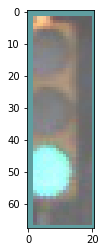

In [13]:
image_cv2 = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


# cv2.imshow('cropped',traffic_light)
# cv2.waitKey(0)

plt.imshow(cv2.cvtColor(traffic_light, cv2.COLOR_BGR2RGB))
plt.show()
